# Start the double resolution process: First the coordinates file

In [183]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [185]:
single = xr.open_dataset('/home/sallen/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
print (single.nav_lat.shape)
single

(898, 398)


<xarray.Dataset>
Dimensions:  (time: 1, x: 398, y: 898)
Coordinates:
  * time     (time) float32 9.969e+36
Dimensions without coordinates: x, y
Data variables: (12/18)
    nav_lon  (y, x) float32 ...
    nav_lat  (y, x) float32 ...
    glamt    (time, y, x) float64 ...
    glamu    (time, y, x) float64 ...
    glamv    (time, y, x) float64 ...
    glamf    (time, y, x) float64 ...
    ...       ...
    e1v      (time, y, x) float64 ...
    e1f      (time, y, x) float64 ...
    e2t      (time, y, x) float64 ...
    e2u      (time, y, x) float64 ...
    e2v      (time, y, x) float64 ...
    e2f      (time, y, x) float64 ...
Attributes:
    history:  [2017-02-14] Compressed Fraser river region

In [16]:
xsize = 2*single.x.shape[0]
ysize = 2*single.y.shape[0]

In [93]:
def duplicate_interpolate(single, ysize, xsize):
    double = np.zeros((ysize, xsize))
    double[0::2, 0::2] = single[:]
    double[1:-1:2, 0::2] = 0.5 * (single[0:-1] + single[1:])
    double[0::2, 1:-1:2] = 0.5 * (single[:, 0:-1] + single[:, 1:])
    double[1:-1:2, 1:-1:2] = 0.5 * (single[0:-1, 0:-1] + single[1:, 1:])
    double[-1, :-1] = 2 * double[-2, :-1] - double[-3, :-1]
    double[:, -1] = 2 * double[:, -2] - double[:, -3]
    return double

In [175]:
def duplicate_split_x(single, ysize, xsize):
    double = np.zeros((ysize, xsize))
    double[0::2, 0::2] = 0.5 * single[:]                      # half exact points
    double[1:-2:2, 0::2] = 0.5 * (double[0:-2:2, 0::2] + double[2::2, 0::2])  # interpolate in y
    double[:, 1::2] = double[:, 0::2]                         # copy in x
    double[-1] = 2 * double[-2] - double[-3]                  # domain top
    return double

In [176]:
def duplicate_split_y(single, ysize, xsize):
    double = np.zeros((ysize, xsize))
    double[0::2, 0::2] = 0.5 * single[:]                      # half exact points
    double[0::2, 1:-2:2] = 0.5 * (double[0::2, 0:-2:2] + double[0::2, 2::2])  # interpolate in x
    double[1::2, :] = double[0::2, :]                         # copy in y
    double[:, -1] = 2 * double[:, -2] - double[:, -3]                  # domain right
    return double

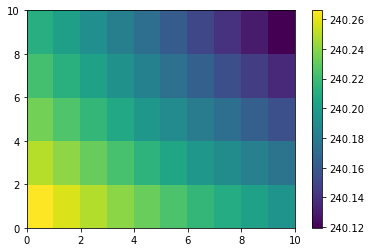

In [178]:
mydouble = duplicate_split_y(single.e2t[0], ysize, xsize)
plt.pcolormesh(mydouble[-10:, -10:])
plt.colorbar();

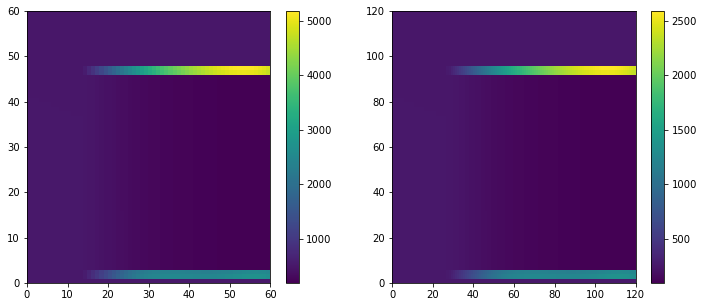

In [179]:
mydouble = duplicate_split_y(single.e2t[0], ysize, xsize)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colours = axs[0].pcolormesh(single.e2t[0, 400:460, 310:370])
fig.colorbar(colours, ax=axs[0])
colours = axs[1].pcolormesh(mydouble[800:920, 620:740]);
fig.colorbar(colours, ax=axs[1]);

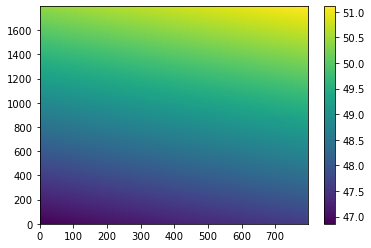

In [96]:
nav_lat = duplicate_interpolate(single.nav_lat[:], ysize, xsize)
plt.pcolormesh(nav_lat)
plt.colorbar();

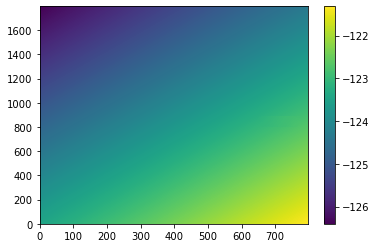

In [97]:
nav_lon = duplicate_interpolate(single.nav_lon[:], ysize, xsize)
plt.pcolormesh(nav_lon)
plt.colorbar();

In [108]:
glamt = np.expand_dims(nav_lon, axis=0)
gphit = np.expand_dims(nav_lat, axis=0)

In [113]:
glamu = np.expand_dims(duplicate_interpolate(single.glamu[0], ysize, xsize), axis=0)
glamv = np.expand_dims(duplicate_interpolate(single.glamv[0], ysize, xsize), axis=0)
glamf = np.expand_dims(duplicate_interpolate(single.glamf[0], ysize, xsize), axis=0)

In [114]:
gphiu = np.expand_dims(duplicate_interpolate(single.gphiu[0], ysize, xsize), axis=0)
gphiv = np.expand_dims(duplicate_interpolate(single.gphiv[0], ysize, xsize), axis=0)
gphif = np.expand_dims(duplicate_interpolate(single.gphif[0], ysize, xsize), axis=0)

In [173]:
e1t = np.expand_dims(duplicate_split_x(single.e1t[0], ysize, xsize), axis=0)
e1u = np.expand_dims(duplicate_split_x(single.e1u[0], ysize, xsize), axis=0)
e1v = np.expand_dims(duplicate_split_x(single.e1v[0], ysize, xsize), axis=0)
e1f = np.expand_dims(duplicate_split_x(single.e1f[0], ysize, xsize), axis=0)

In [180]:
e2t = np.expand_dims(duplicate_split_x(single.e2t[0], ysize, xsize), axis=0)
e2u = np.expand_dims(duplicate_split_x(single.e2u[0], ysize, xsize), axis=0)
e2v = np.expand_dims(duplicate_split_x(single.e2v[0], ysize, xsize), axis=0)
e2f = np.expand_dims(duplicate_split_x(single.e2f[0], ysize, xsize), axis=0)

## Write the File ##

In [181]:
filename = 'coordinates_SalishSea_double_202206.nc'

In [205]:
# Add some global attributes
ds_attrs = {
    'acknowledgements':
        'from Michael Dunphys 201702 stretched river coordinates',
    'creator_email':
        'sallen@eoas.ubc.ca',
    'creator_name':
        'Salish Sea MEOPAR Project Contributors',
    'creator_url':
        'https://salishsea-meopar-docs.readthedocs.org/',
    'institution':
        'UBC EOAS',
    'institution_fullname': (
        'Earth, Ocean & Atmospheric Sciences,'
        ' University of British Columbia'
    ),
    'summary': (
        'Coordinate file, doubled from 201702 coordinates'
    ),
    'source': (
        'tools/double_resolution/coordinates.ipynb'
    ),
    'history': (
        '[{}] File creation.'
        .format(datetime.datetime.today().strftime('%Y-%m-%d'))
    )
}

In [206]:
da = {}
interpl = {
    'nav_lat': nav_lat,
    'nav_lon': nav_lon,
    'glamt': glamt,
    'glamu': glamu,
    'glamv': glamv,
    'glamf': glamf,
    'gphit': gphit,
    'gphiu': gphiu,
    'gphiv': gphiv,
    'gphif': gphiv,
    'e1t': e1t,
    'e1u': e1u,
    'e1v': e1v,
    'e1f': e1f,
    'e2t': e2t,
    'e2u': e2u,
    'e2v': e2v,
    'e2f': e2f
}
for var in interpl.keys():
    if var == 'nav_lat' or var == 'nav_lon':
        dims = ('y', 'x')
        coords = {'y': np.arange(ysize), 'x': np.arange(xsize)}
    else:
        dims = ('time', 'y', 'x')
        coords = {'time': [0], 'y': np.arange(ysize), 'x': np.arange(xsize)}            
    da[var] = xr.DataArray(
        data=interpl[var],
        name=var,
        dims=dims,
        coords=coords,
    )

In [207]:
ds = xr.Dataset(
    data_vars=da,
    coords=coords,
    attrs=ds_attrs
)

In [208]:
ds

<xarray.Dataset>
Dimensions:  (time: 1, x: 796, y: 1796)
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1789 1790 1791 1792 1793 1794 1795
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 787 788 789 790 791 792 793 794 795
  * time     (time) int64 0
Data variables: (12/18)
    nav_lat  (y, x) float64 46.86 46.86 46.86 46.86 ... 51.11 51.11 51.11 51.11
    nav_lon  (y, x) float64 -123.4 -123.4 -123.4 -123.4 ... -124.3 -124.3 -124.3
    glamt    (time, y, x) float64 -123.4 -123.4 -123.4 ... -124.3 -124.3 -124.3
    glamu    (time, y, x) float64 -123.4 -123.4 -123.4 ... -124.3 -124.3 -124.3
    glamv    (time, y, x) float64 -123.4 -123.4 -123.4 ... -124.3 -124.3 -124.3
    glamf    (time, y, x) float64 -123.4 -123.4 -123.4 ... -124.3 -124.3 -124.3
    ...       ...
    e1v      (time, y, x) float64 227.4 227.4 227.3 227.3 ... 182.9 181.8 181.8
    e1f      (time, y, x) float64 227.3 227.3 227.4 227.4 ... 182.4 181.2 181.2
    e2t      (time, y, x) float64 203.6 203.6 209.7 209.7 ... 240.1 240.1 240.1
    e2u      (time, y, x) float64 206.7 206.7 211.9 211.9 ... 240.1 240.1 240.1
    e2v      (time, y, x) float64 198.4 198.4 207.8 207.8 ... 240.1 240.1 240.1
    e2f      (time, y, x) float64 203.1 203.1 210.4 210.4 ... 240.1 240.1 240.1
Attributes:
    acknowledgements:      from Michael Dunphys 201702 stretched river coordi...
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    summary:               Coordinate file, doubled from 201702 coordinates
    source:                tools/double_resolution/coordinates.ipynb
    history:               [2022-06-15] File creation.

In [209]:
encoding = {var: {'zlib': True} for var in ds.data_vars}
ds.to_netcdf(
    path=filename,
    unlimited_dims=('time'),
    encoding=encoding,
)